In [1]:
import os
from IPython.display import display
from datetime import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "svg"

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    auc
)

from sklearnex import patch_sklearn
import pickle
from imblearn.over_sampling import SMOTE

import optuna
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from lightgbm import early_stopping

FOLDER_TO_SAVE_MODELS = 'saved_models'


/home/oli/python/data-analysis/venv-data-analysis/lib/python3.11/site-packages/cupy/_environment.py:447: UserWarning:


--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------




### Exploring and processing the data

In [2]:
# Reading the data 
df_orig = pd.read_csv('creditcard.csv')

In [3]:
# First glance at the dataset
df_orig.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Checking if we've got any missing value
df_orig.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
value_counts = df_orig['Class'].value_counts()
proportions = value_counts / len(df_orig)
pd.DataFrame({
    'Count': value_counts, 
    'Proportion': proportions
})

,Count,Proportion
Class,,
0,284315,0.998273
1,492,0.001727


We are dealing with an extremely imbalanced dataset, where only 0.17% of the transactions are fraudulant. It's really important to consider this class imbalance when building our model.

If I use the original data to calculate the correlation matrix, it will be influenced by the class imbalance, with non-fraud cases dominating the fraud cases. This could lead us to distorted results. 

In [6]:
# Oversampling the original data using the SMOTE algorithm
smote = SMOTE(random_state=1234)
X_smote, y_smote = smote.fit_resample(df_orig.drop(columns='Class'), df_orig['Class'])
df_smote = X_smote.join(y_smote)

Text(0.5, 1.05, 'Correlation heatmap:\noversampled data')

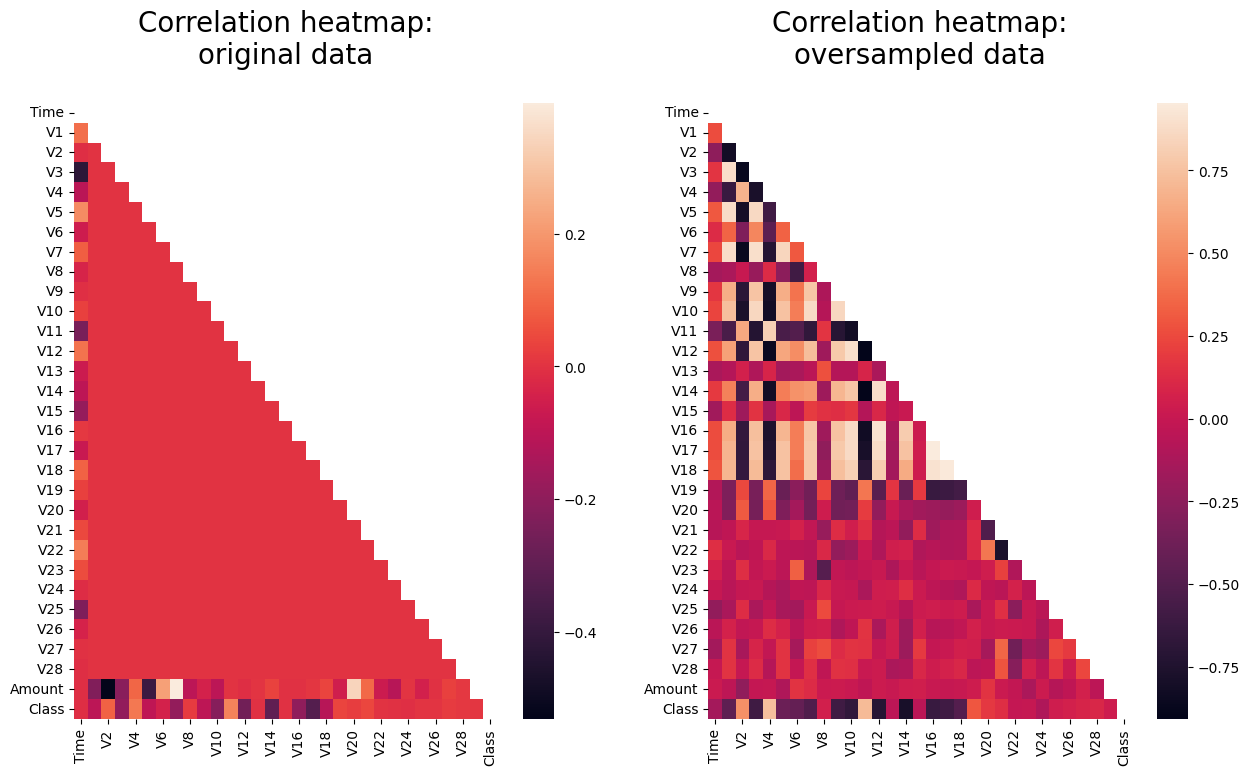

In [7]:
# Let's plot the correlation heatmaps for both the original data and the oversampled data.
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(8)
f.set_figwidth(15)
mask = np.triu(np.ones_like(df_orig.corr(), dtype=bool))
sns.heatmap(df_orig.corr(), mask = mask, ax=ax1)
ax1.set_title("Correlation heatmap:\noriginal data",fontsize=20, y=1.05)
sns.heatmap(df_smote.corr(), mask = mask, ax=ax2)
ax2.set_title("Correlation heatmap:\noversampled data",fontsize=20, y=1.05)

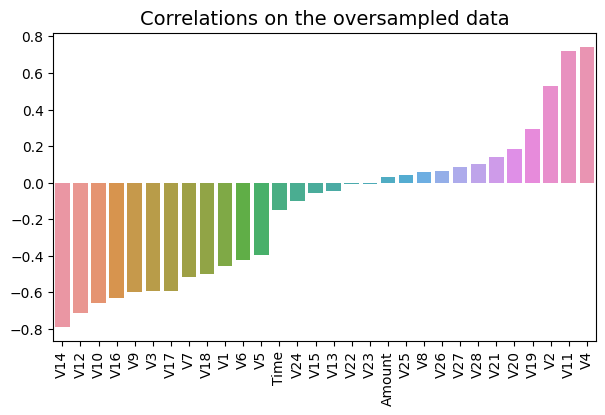

In [8]:
# Creating a pd Series containing the columns with their correlation values based on the oversampled dataset
correlations = df_smote.corr()['Class'].sort_values()
correlations = correlations.loc[correlations.index != 'Class']

# Plot the correlations on a barplot
plt.figure(figsize = (7,4))
plt.title('Correlations on the oversampled data',fontsize=14)
s = sns.barplot(y=correlations, x=correlations.index)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
s.set_ylabel("")
plt.show()  

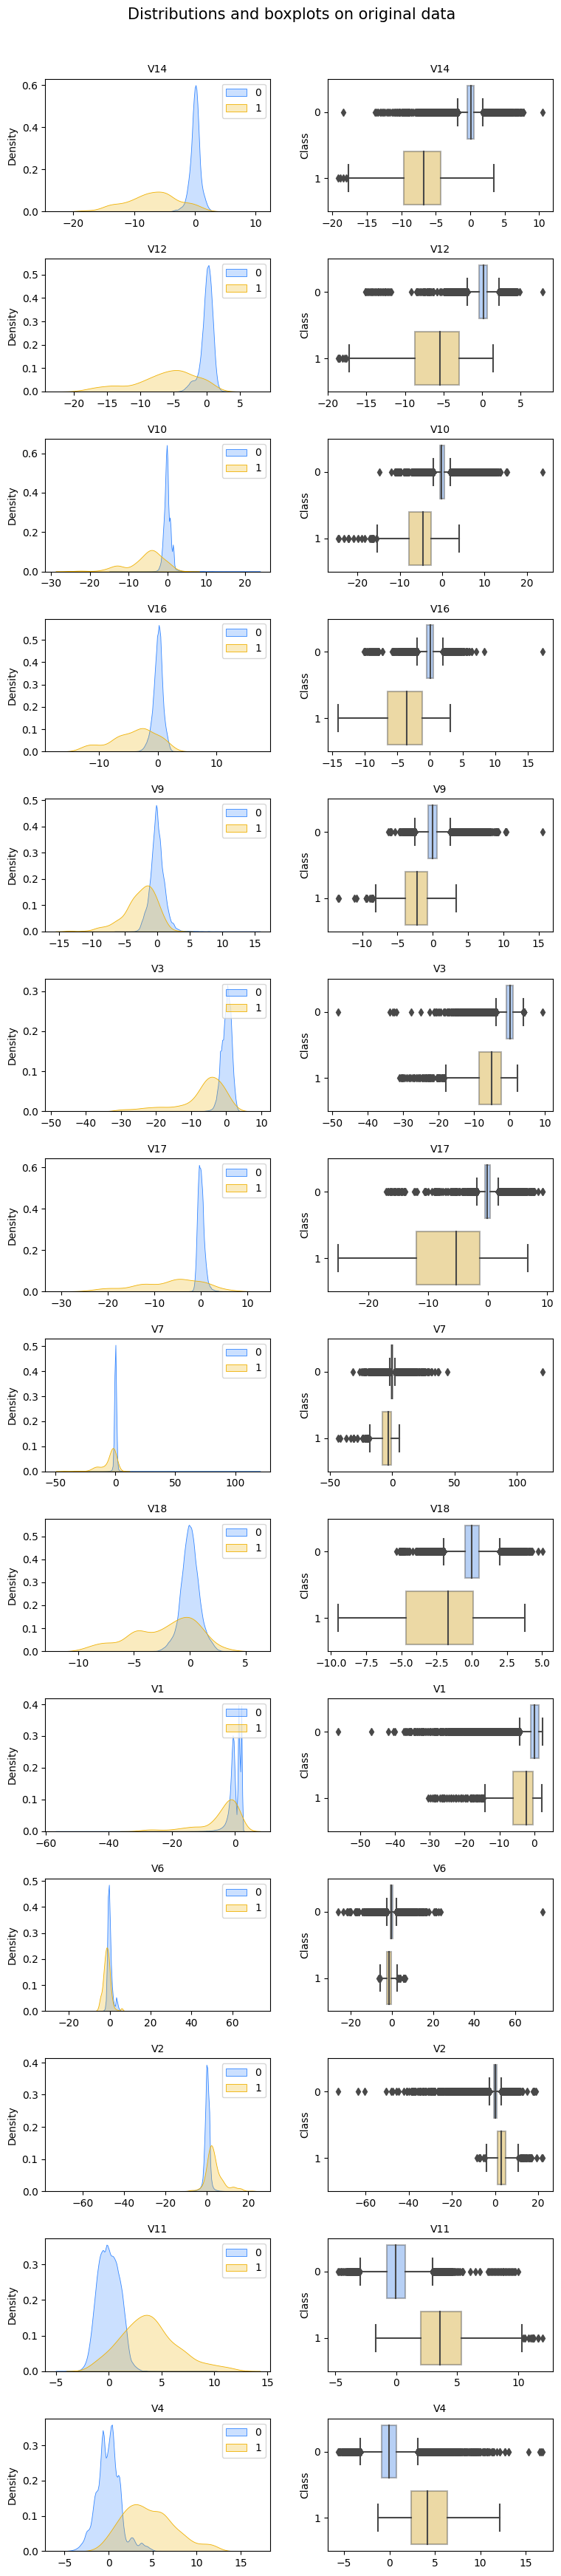

In [9]:
important_features = correlations[np.abs(correlations) > 0.4].index

f, axes = plt.subplots(len(important_features),2)
f.suptitle('Distributions and boxplots on original data',fontsize=15,y=1.0005)
f.set_figheight(2.5*len(important_features))
f.set_figwidth(8)
f.tight_layout(pad=2.5)

for i, feature in enumerate(important_features):

    sns.kdeplot(
        data = df_orig.loc[df_orig.Class == 0], 
        x = feature, 
        fill = True, 
        color ="#3386FF",
        linewidth=0.6, 
        ax=axes[i,0], 
        label=0
    )
    
    sns.kdeplot(
        data = df_orig.loc[df_orig.Class == 1], 
        x = feature, 
        fill = True, 
        color ="#EFB000",
        linewidth=0.6, 
        ax=axes[i,0], 
        label=1
    )
    
    axes[i,0].set_xlabel('')
    axes[i,0].legend()
    axes[i,0].set_title(feature,fontsize=10, y=1.00)


    sns.boxplot(x = df_orig[feature],
                y = df_orig['Class'],
                orient='h',
                palette= ["#3386FF","#EFB000"],
                ax=axes[i][1],
                boxprops=dict(alpha=.4)
    )
    axes[i,1].set_xlabel('')
    axes[i][1].set_title(feature,fontsize=10, y=1.00)


As the boxplots show us, our dataset contains several outliers. Removing these outliers would eliminate a significant number of observations from the fraud cases.

Additionally, this approach may lead to a loss of valuable information and potentially weaken the generalization capability of our model, i.e. it might achieve better results on this dataset but could perform poorly on unseen, real-life data.

Furthermore, considering the fact that we are working mostly with features that were transformed by PCA, I believe it is wiser to put the emphasis on building a robust model instead of trying to figure out what is considered to be an outlier. 

In [10]:
df = df_orig

X = df.drop(columns='Class')
y = df['Class']

In [11]:
# Splitting the dataset into a test and train set. 
# I will perform cross validation on the trainset, and eventually I will test on the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

Here, I am implementing some functions that will be used during the optimization and the evaluation process of our models."

In [12]:

def predict_threshold(threshold, model, x):
    """ 
    Make binary predictions based on the given threshold
    """

    return np.array([int(x[0] <threshold) for x in model.predict_proba(x)])


def optimize_objective(objective, n_trials, direction):
    """
    Optimize an objective function using Optuna.
    """
    
    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    return study


def evaluate_model(model, x_test, y_test):

    """
    Evaluate the model's performance on test data and print out and visualize some metrics.

    Returns:
    - results_df_diff_thresholds: A DataFrame containing metrics for different thresholds.
    - auc_precision_recall: Area Under the PR Curve (AUCPR).
    - lr_recall: Recall values for the Precision-Recall Curve.
    - lr_precision: Precision values for the Precision-Recall Curve.

    """

    # Get the results. 
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1]


    # dictionary to store the metrics on different thresholds
    results_on_diff_threshold = {
        'threshold': [],
        'precision': [],
        'recall': [],
        'FN': [],
        'FP': [],
        'TP': [],
        'TN': [],
    }
    
    # loop trough the different thresholds and populate the results_on_diff_threshold dict
    for i in np.linspace(0.1,0.9,9):

        results_on_diff_threshold['threshold'].append(i)

        y_pred_threshold = predict_threshold(i,model, X_test)

        recall = recall_score(y_test, y_pred_threshold)
        precision = precision_score(y_test, y_pred_threshold)

        results_on_diff_threshold['precision'].append(precision)
        results_on_diff_threshold['recall'].append(recall)

        cm_threshold = confusion_matrix(y_test, y_pred_threshold)
        tn, fp, fn, tp = cm_threshold.ravel()

        results_on_diff_threshold['FN'].append(fn)
        results_on_diff_threshold['FP'].append(fp)
        results_on_diff_threshold['TP'].append(tp)
        results_on_diff_threshold['TN'].append(tn)

    # Getting the data for the PR curve
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_proba)

    # auc score
    auc_precision_recall = auc(lr_recall, lr_precision)

    results_df_diff_thresholds = pd.DataFrame(results_on_diff_threshold)

    # Printing out the results
    print("-------------------- Evaulation scores --------------------\n")
    print(classification_report(y_test, y_pred))
    print("-----------------------------------------------------------")
    print(f"AUCPR score: {auc_precision_recall:.4f}\n")
    print("-----------------------------------------------------------")
    print("Metrics when different threshold is used on test data: ")

    display(results_df_diff_thresholds)
    print("\n")

    plt.figure(figsize = (5,5))
    plt.plot(lr_recall, lr_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

    return results_df_diff_thresholds, auc_precision_recall, lr_recall, lr_precision

### Random forest - optimized with RandomSearchCV 

In [16]:
# Enable the intel extension to boost performance in time
patch_sklearn(['RandomForestClassifier'])


class_weights = {1: np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])}

param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500],
    'class_weight':[class_weights]
}



kfold = StratifiedKFold(n_splits=3)

model_rf = RandomizedSearchCV(
        RandomForestClassifier(n_jobs=-1),
        param_grid,
        cv=kfold,
        scoring= 'neg_log_loss',
        verbose=1,
        n_iter=30,
        random_state=42 
)


model_rf.fit(X_train, y_train)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(n_jobs=-1), n_iter=30,
                   param_distributions={'class_weight': [{1: 24.026793419648342}],
                                        'max_depth': [80, 90, 100, 110],
                                        'max_features': [2, 3],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='neg_log_loss', verbose=1)

-------------------- Evaulation scores --------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.85      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

-----------------------------------------------------------
AUCPR score: 0.8850

-----------------------------------------------------------
Metrics when different threshold is used on test data: 


,threshold,precision,recall,FN,FP,TP,TN
0,0.1,0.955224,0.653061,34,3,64,56861
1,0.2,0.961039,0.755102,24,3,74,56861
2,0.3,0.962500,0.785714,21,3,77,56861
3,0.4,0.929412,0.806122,19,6,79,56858
4,0.5,0.892473,0.846939,15,10,83,56854
5,0.6,0.848485,0.857143,14,15,84,56849
6,0.7,0.825243,0.867347,13,18,85,56846
7,0.8,0.781818,0.877551,12,24,86,56840
8,0.9,0.676923,0.897959,10,42,88,56822


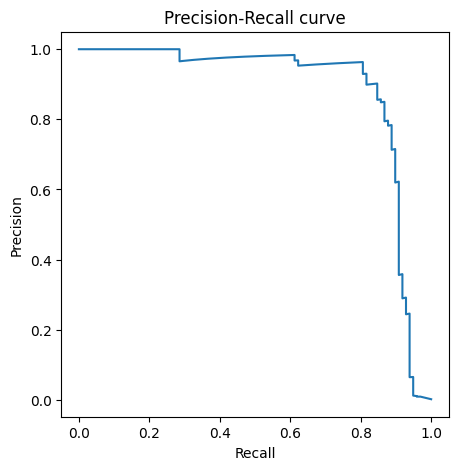

In [17]:
result_rf = evaluate_model(model_rf, X_test, y_test)

In [18]:
# Saving our model with the best performance

# Check if the folder exists
if not os.path.exists(FOLDER_TO_SAVE_MODELS):
    # If it doesn't exist, create the folder
    os.mkdir(FOLDER_TO_SAVE_MODELS)

filename = os.path.join(FOLDER_TO_SAVE_MODELS,f"Random-forest-{datetime.now().strftime('%Y%m%d')}.sav")
pickle.dump(model_rf, open(filename, 'wb'))

# Example to load rf model
# loaded_model_rf = pickle.load(open(filename, 'rb'))

### XGBOOST classifier - optimized with OPTUNA

In [13]:
def objective_xgb(
        trial,
        eval_metric='logloss',
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        y_test=y_test,
        seed=42,
        n_folds=3,
):
    
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_test, label=y_test)

    pos_weight = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])

    param = {
        "verbosity":0,
        'objective':trial.suggest_categorical('objective',['binary:logistic']),
        "eval_metric": [eval_metric],
        'predictor': trial.suggest_categorical('predictor',['gpu_predictor']),
        'tree_method':trial.suggest_categorical('tree_method',['gpu_hist']),
        'lambda'           : trial.suggest_float('lambda', 1e-3, 5.0),
        'alpha'            : trial.suggest_float('alpha', 1e-3, 5.0),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 150),
        'subsample'        : trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        'max_depth'        : trial.suggest_int("max_depth", 1, 9),
        'eta'    : trial.suggest_categorical('eta', [0.001,0.01,0.05,0.1,0.2,0.25,0.3]),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight',[pos_weight])
    }

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f"test-{eval_metric}")

    xgb_cv_results = xgb.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=10000,
        callbacks=[pruning_callback],
        nfold=n_folds,
        stratified=True,
        early_stopping_rounds=100,
        seed=seed,
        verbose_eval=False,
    )

    # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
    trial.set_user_attr("n_estimators", len(xgb_cv_results))

    # Extract the best score.
    best_score = xgb_cv_results[f"test-{eval_metric}-mean"].values[-1]
    return best_score


In [14]:
study_xgb = optimize_objective(
    objective=objective_xgb,
    n_trials=30,
    direction="minimize"
)

[I 2023-10-12 20:40:20,897] A new study created in memory with name: no-name-d229e91e-df19-4576-b2b7-a47b6095e038
[I 2023-10-12 20:40:25,546] Trial 0 finished with value: 0.0044175562552362995 and parameters: {'objective': 'binary:logistic', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'lambda': 1.905999886429081, 'alpha': 3.3488975102567196, 'min_child_weight': 113, 'subsample': 0.6269501675687212, 'colsample_bytree': 0.4759922487328787, 'max_depth': 8, 'eta': 0.25, 'scale_pos_weight': 24.026793419648342}. Best is trial 0 with value: 0.0044175562552362995.
[I 2023-10-12 20:40:34,788] Trial 1 finished with value: 0.0031018447380539503 and parameters: {'objective': 'binary:logistic', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'lambda': 3.3355736442481363, 'alpha': 3.4544574025085075, 'min_child_weight': 30, 'subsample': 0.4315344689891533, 'colsample_bytree': 0.8200338795942568, 'max_depth': 6, 'eta': 0.05, 'scale_pos_weight': 24.026793419648342}. Best is trial

Number of finished trials:  30
Best trial:
  Value: 0.0026926134115559802
  Params: 
    objective: binary:logistic
    predictor: gpu_predictor
    tree_method: gpu_hist
    lambda: 3.7885475047800745
    alpha: 2.7476793383055296
    min_child_weight: 16
    subsample: 0.9333099283680251
    colsample_bytree: 0.5987128676315583
    max_depth: 8
    eta: 0.05
    scale_pos_weight: 24.026793419648342


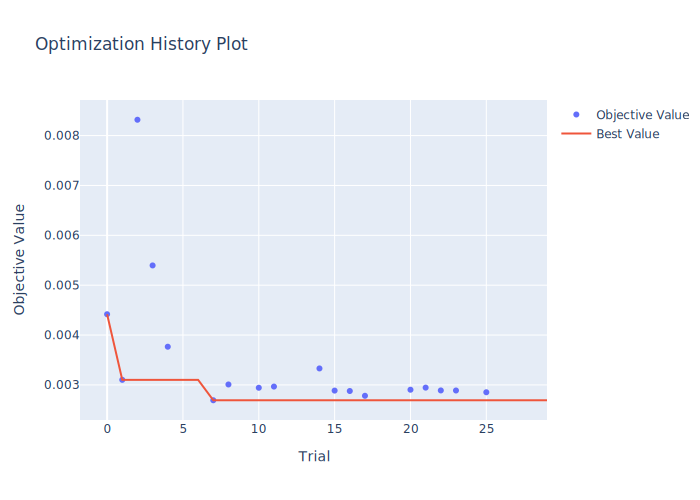

In [15]:
optuna.visualization.plot_optimization_history(study_xgb)

-------------------- Evaulation scores --------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.86      0.88        98

    accuracy                           1.00     56962
   macro avg       0.96      0.93      0.94     56962
weighted avg       1.00      1.00      1.00     56962

-----------------------------------------------------------
AUCPR score: 0.8981

-----------------------------------------------------------
Metrics when different threshold is used on test data: 


,threshold,precision,recall,FN,FP,TP,TN
0,0.1,0.964286,0.826531,17,3,81,56861
1,0.2,0.953488,0.836735,16,4,82,56860
2,0.3,0.931818,0.836735,16,6,82,56858
3,0.4,0.922222,0.846939,15,7,83,56857
4,0.5,0.913043,0.857143,14,8,84,56856
5,0.6,0.904255,0.867347,13,9,85,56855
6,0.7,0.885417,0.867347,13,11,85,56853
7,0.8,0.851485,0.877551,12,15,86,56849
8,0.9,0.750000,0.887755,11,29,87,56835


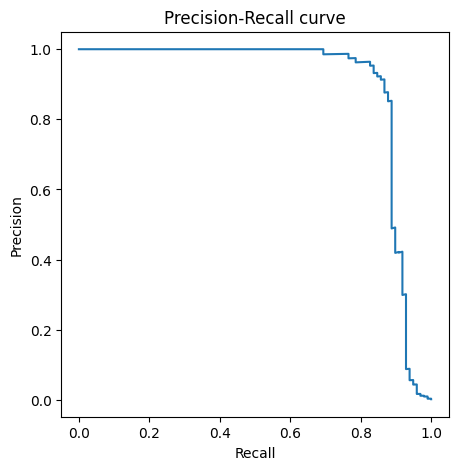

In [19]:
def create_fit_xgb(study, x, y):

    model = xgb.XGBClassifier(
        **study.best_params, 
        n_estimators = study.best_trial.user_attrs['n_estimators']
    )
    model.fit(x, y)

    return model

model_xgb = create_fit_xgb(study_xgb, X_train, y_train)
result_xgb = evaluate_model(model_xgb, X_test, y_test)

In [20]:
# Saving the model with the best performance
model_xgb.save_model(os.path.join(FOLDER_TO_SAVE_MODELS,f"XGB-{datetime.now().strftime('%Y%m%d')}.json"))

# Example to load model
# loaded_model_xgb = xgb.XGBClassifier()
# loaded_model_xgb.load_model("model_sklearn.json")

### CATBOOST + OPTUNA

In [21]:
def objective_cb(
        trial,
        eval_metric='Logloss', 
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        y_test=y_test,
        seed=42,
        n_folds=3
):
    
        train_pool = cb.Pool(data=x_train, label=y_train, has_header=True)
        test_pool = cb.Pool(data=x_test, label=y_test, has_header=True)

        pos_weight = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])

        params = {
                "objective": trial.suggest_categorical("objective", ["Logloss"]),
                # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
                "depth": trial.suggest_int("depth", 1, 12),
                "learning_rate":trial.suggest_float("learning_rate", 1e-3, 1, log=True),
                # With this amount of data ordered boosting_type would make our training 
                "boosting_type": trial.suggest_categorical("boosting_type", ["Plain"]),
                "bootstrap_type": trial.suggest_categorical(
                "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
                ),
                "scale_pos_weight": trial.suggest_categorical('scale_pos_weight',[pos_weight]),
                "task_type":trial.suggest_categorical("task_type",["GPU"]),
                "verbose": False

        }

        if params["bootstrap_type"] == "Bayesian":
                params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif params["bootstrap_type"] == "Bernoulli":
                params["subsample"] = trial.suggest_float("subsample", 0.1, 1)


        catboost_cv_results = cb.cv(train_pool,
                params,
                nfold=n_folds,
                stratified=True,
                early_stopping_rounds=100,
                seed=seed,
                verbose=0
                
        )


        # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
        trial.set_user_attr("iterations", len(catboost_cv_results))

        # Extract the best score.
        best_score = catboost_cv_results[F"test-{eval_metric}-mean"].values[-1]
        return best_score


In [22]:
study_cb = optimize_objective(
    objective=objective_cb,
    n_trials=30,
    direction="minimize"
)

[I 2023-10-12 20:52:49,317] A new study created in memory with name: no-name-32da697e-19db-4d8d-918e-98e9dbd0513b


Training on fold [0/3]
bestTest = 0.03675351433
bestIteration = 17
Training on fold [1/3]
bestTest = 0.03100429344
bestIteration = 24
Training on fold [2/3]


[I 2023-10-12 20:53:08,288] Trial 0 finished with value: 0.05347387797350559 and parameters: {'objective': 'Logloss', 'depth': 12, 'learning_rate': 0.07957949220448862, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 8.117904579491695}. Best is trial 0 with value: 0.05347387797350559.


bestTest = 0.04355662423
bestIteration = 16
Training on fold [0/3]
bestTest = 0.03515955488
bestIteration = 337
Training on fold [1/3]
bestTest = 0.02767540563
bestIteration = 522
Training on fold [2/3]


[I 2023-10-12 20:53:12,714] Trial 1 finished with value: 0.036313492081677036 and parameters: {'objective': 'Logloss', 'depth': 6, 'learning_rate': 0.010749749273254918, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.6188195580092978}. Best is trial 1 with value: 0.036313492081677036.


bestTest = 0.04537233793
bestIteration = 209
Training on fold [0/3]
bestTest = 0.03905256451
bestIteration = 26
Training on fold [1/3]
bestTest = 0.03184832366
bestIteration = 40
Training on fold [2/3]


[I 2023-10-12 20:53:13,808] Trial 2 finished with value: 0.040233607642271574 and parameters: {'objective': 'Logloss', 'depth': 3, 'learning_rate': 0.28677341564219144, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 1 with value: 0.036313492081677036.


bestTest = 0.04860954839
bestIteration = 26
Training on fold [0/3]
bestTest = 0.04455138695
bestIteration = 1
Training on fold [1/3]
bestTest = 0.03708894647
bestIteration = 6
Training on fold [2/3]


[I 2023-10-12 20:53:18,734] Trial 3 finished with value: 0.09141169830189703 and parameters: {'objective': 'Logloss', 'depth': 10, 'learning_rate': 0.6623102785931201, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 1 with value: 0.036313492081677036.


bestTest = 0.05725638435
bestIteration = 1
Training on fold [0/3]
bestTest = 0.0352966829
bestIteration = 175
Training on fold [1/3]
bestTest = 0.02750720372
bestIteration = 228
Training on fold [2/3]


[I 2023-10-12 20:53:21,586] Trial 4 finished with value: 0.03617776053548704 and parameters: {'objective': 'Logloss', 'depth': 6, 'learning_rate': 0.019613528541346372, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.55774673593749}. Best is trial 4 with value: 0.03617776053548704.


bestTest = 0.04375586139
bestIteration = 138
Training on fold [0/3]
bestTest = 0.03625317602
bestIteration = 22
Training on fold [1/3]
bestTest = 0.03008408494
bestIteration = 27
Training on fold [2/3]


[I 2023-10-12 20:53:31,919] Trial 5 finished with value: 0.05050789313633778 and parameters: {'objective': 'Logloss', 'depth': 11, 'learning_rate': 0.07500888760727514, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 1.086257823441572}. Best is trial 4 with value: 0.03617776053548704.


bestTest = 0.04376632087
bestIteration = 20
Training on fold [0/3]
bestTest = 0.03434531747
bestIteration = 408
Training on fold [1/3]
bestTest = 0.02709468963
bestIteration = 491
Training on fold [2/3]


[I 2023-10-12 20:53:35,948] Trial 6 finished with value: 0.03549150233007151 and parameters: {'objective': 'Logloss', 'depth': 5, 'learning_rate': 0.014134139989780097, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.5390784234929732}. Best is trial 6 with value: 0.03549150233007151.


bestTest = 0.04422629681
bestIteration = 333
Training on fold [0/3]
bestTest = 0.035391995
bestIteration = 73
Training on fold [1/3]
bestTest = 0.02896910999
bestIteration = 53
Training on fold [2/3]


[I 2023-10-12 20:53:37,571] Trial 7 finished with value: 0.04064998715951588 and parameters: {'objective': 'Logloss', 'depth': 5, 'learning_rate': 0.10452655353335377, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 4.111089981856166}. Best is trial 6 with value: 0.03549150233007151.


bestTest = 0.04582964567
bestIteration = 75
Training on fold [0/3]
bestTest = 0.03946232897
bestIteration = 999
Training on fold [1/3]
bestTest = 0.03804697976
bestIteration = 999
Training on fold [2/3]


[I 2023-10-12 20:53:59,024] Trial 8 finished with value: 0.042579435984336 and parameters: {'objective': 'Logloss', 'depth': 9, 'learning_rate': 0.0015037443270822823, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 6 with value: 0.03549150233007151.


bestTest = 0.05022899922
bestIteration = 999
Training on fold [0/3]
bestTest = 0.03894551959
bestIteration = 35
Training on fold [1/3]
bestTest = 0.02960532646
bestIteration = 60
Training on fold [2/3]


[I 2023-10-12 20:54:02,139] Trial 9 finished with value: 0.047175423827413354 and parameters: {'objective': 'Logloss', 'depth': 8, 'learning_rate': 0.05179862234199213, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 6 with value: 0.03549150233007151.


bestTest = 0.04654474263
bestIteration = 48
Training on fold [0/3]
bestTest = 0.03874912171
bestIteration = 999
Training on fold [1/3]
bestTest = 0.03124503152
bestIteration = 998
Training on fold [2/3]


[I 2023-10-12 20:54:07,186] Trial 10 finished with value: 0.03946198569253271 and parameters: {'objective': 'Logloss', 'depth': 1, 'learning_rate': 0.0070197330600554, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.20517927552752413}. Best is trial 6 with value: 0.03549150233007151.


bestTest = 0.04839093506
bestIteration = 999
Training on fold [0/3]
bestTest = 0.03393514193
bestIteration = 487
Training on fold [1/3]
bestTest = 0.02703142571
bestIteration = 543
Training on fold [2/3]


[I 2023-10-12 20:54:12,000] Trial 11 finished with value: 0.035248471987989145 and parameters: {'objective': 'Logloss', 'depth': 4, 'learning_rate': 0.014761949115699028, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.6336636823165305}. Best is trial 11 with value: 0.035248471987989145.


bestTest = 0.04418861115
bestIteration = 576
Training on fold [0/3]
bestTest = 0.03445058206
bestIteration = 993
Training on fold [1/3]
bestTest = 0.02854899941
bestIteration = 997
Training on fold [2/3]


[I 2023-10-12 20:54:19,803] Trial 12 finished with value: 0.035907586418109275 and parameters: {'objective': 'Logloss', 'depth': 4, 'learning_rate': 0.004649613582251781, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.9534857854503509}. Best is trial 11 with value: 0.035248471987989145.


bestTest = 0.04467467241
bestIteration = 968
Training on fold [0/3]
bestTest = 0.03271011699
bestIteration = 998
Training on fold [1/3]
bestTest = 0.02738544647
bestIteration = 497
Training on fold [2/3]


[I 2023-10-12 20:54:24,920] Trial 13 finished with value: 0.034247723588956856 and parameters: {'objective': 'Logloss', 'depth': 2, 'learning_rate': 0.02500343018865056, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.6234219352365457}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04244608288
bestIteration = 996
Training on fold [0/3]
bestTest = 0.03504901732
bestIteration = 999
Training on fold [1/3]
bestTest = 0.02790363438
bestIteration = 993
Training on fold [2/3]


[I 2023-10-12 20:54:32,758] Trial 14 finished with value: 0.035625672662461486 and parameters: {'objective': 'Logloss', 'depth': 1, 'learning_rate': 0.025184670432713014, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.7550032254379847}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04390918876
bestIteration = 996
Training on fold [0/3]
bestTest = 0.03381466115
bestIteration = 520
Training on fold [1/3]
bestTest = 0.02681602474
bestIteration = 452
Training on fold [2/3]


[I 2023-10-12 20:54:38,090] Trial 15 finished with value: 0.03487032598616696 and parameters: {'objective': 'Logloss', 'depth': 3, 'learning_rate': 0.030492929583280513, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.3975669612991669}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04321304439
bestIteration = 511
Training on fold [0/3]
bestTest = 0.03414192193
bestIteration = 995
Training on fold [1/3]
bestTest = 0.02799806341
bestIteration = 528
Training on fold [2/3]


[I 2023-10-12 20:54:43,922] Trial 16 finished with value: 0.03503978154712928 and parameters: {'objective': 'Logloss', 'depth': 2, 'learning_rate': 0.029360899752066995, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.3203412501999892}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04270103386
bestIteration = 705
Training on fold [0/3]
bestTest = 0.03632733444
bestIteration = 999
Training on fold [1/3]
bestTest = 0.02962876831
bestIteration = 999
Training on fold [2/3]


[I 2023-10-12 20:54:51,438] Trial 17 finished with value: 0.037131181404835185 and parameters: {'objective': 'Logloss', 'depth': 3, 'learning_rate': 0.004019912131608112, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.36884011085686946}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04543744147
bestIteration = 999
Training on fold [0/3]
bestTest = 0.03426244598
bestIteration = 518
Training on fold [1/3]
bestTest = 0.02777507522
bestIteration = 594
Training on fold [2/3]


[I 2023-10-12 20:54:56,451] Trial 18 finished with value: 0.03516047550420092 and parameters: {'objective': 'Logloss', 'depth': 2, 'learning_rate': 0.03914695799641326, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.11410500763593212}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04307112258
bestIteration = 725
Training on fold [0/3]
bestTest = 0.03642872004
bestIteration = 24
Training on fold [1/3]
bestTest = 0.02897462572
bestIteration = 33
Training on fold [2/3]


[I 2023-10-12 20:54:59,605] Trial 19 finished with value: 0.047320957428779 and parameters: {'objective': 'Logloss', 'depth': 8, 'learning_rate': 0.1002515467960575, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 8.4584689785565}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04786407473
bestIteration = 20
Training on fold [0/3]
bestTest = 0.0333774068
bestIteration = 91
Training on fold [1/3]
bestTest = 0.02707124779
bestIteration = 41
Training on fold [2/3]


[I 2023-10-12 20:55:01,324] Trial 20 finished with value: 0.0384491785458153 and parameters: {'objective': 'Logloss', 'depth': 3, 'learning_rate': 0.17359458217260995, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.4270358867900506}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04195968153
bestIteration = 103
Training on fold [0/3]
bestTest = 0.03395782248
bestIteration = 985
Training on fold [1/3]
bestTest = 0.02821898629
bestIteration = 458
Training on fold [2/3]


[I 2023-10-12 20:55:06,558] Trial 21 finished with value: 0.0351912914619705 and parameters: {'objective': 'Logloss', 'depth': 2, 'learning_rate': 0.034077396383772614, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.30092038873619814}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04293839571
bestIteration = 549
Training on fold [0/3]
bestTest = 0.03541223379
bestIteration = 999
Training on fold [1/3]
bestTest = 0.02843416775
bestIteration = 963
Training on fold [2/3]


[I 2023-10-12 20:55:13,011] Trial 22 finished with value: 0.0363555248665181 and parameters: {'objective': 'Logloss', 'depth': 1, 'learning_rate': 0.027390042718284, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.4228644099213409}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04519014882
bestIteration = 976
Training on fold [0/3]
bestTest = 0.03431778739
bestIteration = 311
Training on fold [1/3]
bestTest = 0.02792355469
bestIteration = 174
Training on fold [2/3]


[I 2023-10-12 20:55:16,169] Trial 23 finished with value: 0.036180386215899994 and parameters: {'objective': 'Logloss', 'depth': 4, 'learning_rate': 0.04814650512511854, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.33393077712793245}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04269673938
bestIteration = 240
Training on fold [0/3]
bestTest = 0.03375316897
bestIteration = 995
Training on fold [1/3]
bestTest = 0.02834191532
bestIteration = 580
Training on fold [2/3]


[I 2023-10-12 20:55:21,634] Trial 24 finished with value: 0.03531469633314377 and parameters: {'objective': 'Logloss', 'depth': 2, 'learning_rate': 0.022216713590453657, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.2430351946360704}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.0437059292
bestIteration = 558
Training on fold [0/3]
bestTest = 0.03465180165
bestIteration = 999
Training on fold [1/3]
bestTest = 0.02808667681
bestIteration = 963
Training on fold [2/3]


[I 2023-10-12 20:55:28,705] Trial 25 finished with value: 0.035508922134794674 and parameters: {'objective': 'Logloss', 'depth': 2, 'learning_rate': 0.010527012082715125, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.45937143842580214}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04363593448
bestIteration = 984
Training on fold [0/3]
bestTest = 0.03487746666
bestIteration = 177
Training on fold [1/3]
bestTest = 0.0278220424
bestIteration = 160
Training on fold [2/3]


[I 2023-10-12 20:55:31,400] Trial 26 finished with value: 0.036097383726478104 and parameters: {'objective': 'Logloss', 'depth': 5, 'learning_rate': 0.03539087087552677, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.2970004404830432}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04361161765
bestIteration = 98
Training on fold [0/3]
bestTest = 0.03421260625
bestIteration = 507
Training on fold [1/3]
bestTest = 0.02689887816
bestIteration = 827
Training on fold [2/3]


[I 2023-10-12 20:55:37,606] Trial 27 finished with value: 0.03475063136461387 and parameters: {'objective': 'Logloss', 'depth': 3, 'learning_rate': 0.016560839419541267, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.46369081106044685}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04287935206
bestIteration = 748
Training on fold [0/3]
bestTest = 0.03570110639
bestIteration = 330
Training on fold [1/3]
bestTest = 0.02826802805
bestIteration = 498
Training on fold [2/3]


[I 2023-10-12 20:55:45,234] Trial 28 finished with value: 0.03643579212705915 and parameters: {'objective': 'Logloss', 'depth': 7, 'learning_rate': 0.007605739684905092, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 0.40750358853415847}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04461665831
bestIteration = 327
Training on fold [0/3]
bestTest = 0.03586989693
bestIteration = 59
Training on fold [1/3]
bestTest = 0.02911916008
bestIteration = 64
Training on fold [2/3]


[I 2023-10-12 20:55:58,650] Trial 29 finished with value: 0.04326376727288705 and parameters: {'objective': 'Logloss', 'depth': 12, 'learning_rate': 0.061089993563919635, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 13 with value: 0.034247723588956856.


bestTest = 0.04562279037
bestIteration = 53
Number of finished trials:  30
Best trial:
  Value: 0.034247723588956856
  Params: 
    objective: Logloss
    depth: 2
    learning_rate: 0.02500343018865056
    boosting_type: Plain
    bootstrap_type: Bernoulli
    scale_pos_weight: 24.026793419648342
    task_type: GPU
    subsample: 0.6234219352365457


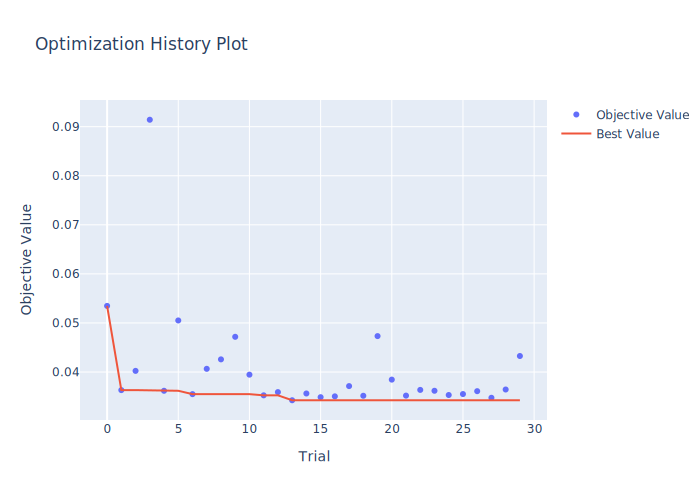

In [23]:
optuna.visualization.plot_optimization_history(study_cb)

In [24]:
def create_fit_cb(study, x, y):

    model = cb.CatBoostClassifier(
        **study.best_params,
        iterations=study_cb.best_trial.user_attrs['iterations']
    )
    model.fit(x, y,verbose=True)

    return model


model_cb = create_fit_cb(study_cb, X_train, y_train)

0:	learn: 0.6347902	total: 3.87ms	remaining: 3.87s
1:	learn: 0.5813867	total: 6.07ms	remaining: 3.03s
2:	learn: 0.5328349	total: 8.2ms	remaining: 2.72s
3:	learn: 0.4885635	total: 11.7ms	remaining: 2.91s
4:	learn: 0.4486989	total: 13.9ms	remaining: 2.76s
5:	learn: 0.4141126	total: 17.3ms	remaining: 2.87s
6:	learn: 0.3826361	total: 19.4ms	remaining: 2.75s
7:	learn: 0.3525729	total: 22.8ms	remaining: 2.83s
8:	learn: 0.3251261	total: 25.1ms	remaining: 2.77s
9:	learn: 0.3000816	total: 28.7ms	remaining: 2.84s
10:	learn: 0.2774499	total: 31ms	remaining: 2.79s
11:	learn: 0.2580091	total: 34.4ms	remaining: 2.83s
12:	learn: 0.2402387	total: 36.5ms	remaining: 2.77s
13:	learn: 0.2237756	total: 39.8ms	remaining: 2.81s
14:	learn: 0.2095272	total: 42ms	remaining: 2.76s
15:	learn: 0.1945801	total: 44.2ms	remaining: 2.72s
16:	learn: 0.1823839	total: 47.6ms	remaining: 2.75s
17:	learn: 0.1714603	total: 49.9ms	remaining: 2.72s
18:	learn: 0.1619007	total: 53.5ms	remaining: 2.76s
19:	learn: 0.1522419	total:

-------------------- Evaulation scores --------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.75      0.88      0.81        98

    accuracy                           1.00     56962
   macro avg       0.88      0.94      0.91     56962
weighted avg       1.00      1.00      1.00     56962

-----------------------------------------------------------
AUCPR score: 0.8322

-----------------------------------------------------------
Metrics when different threshold is used on test data: 


,threshold,precision,recall,FN,FP,TP,TN
0,0.1,0.857143,0.795918,20,13,78,56851
1,0.2,0.824742,0.816327,18,17,80,56847
2,0.3,0.821782,0.846939,15,18,83,56846
3,0.4,0.792453,0.857143,14,22,84,56842
4,0.5,0.754386,0.877551,12,28,86,56836
5,0.6,0.688000,0.877551,12,39,86,56825
6,0.7,0.580000,0.887755,11,63,87,56801
7,0.8,0.450000,0.918367,8,110,90,56754
8,0.9,0.272455,0.928571,7,243,91,56621


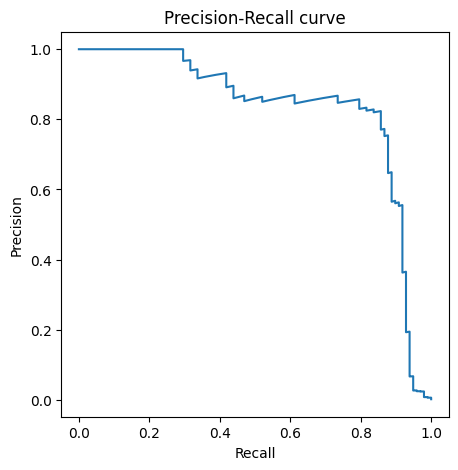

In [25]:
result_cb = evaluate_model(model_cb, X_test, y_test)

In [26]:
# Saving the model with the best performance
model_cb.save_model(os.path.join(FOLDER_TO_SAVE_MODELS,f"CatBoost-{datetime.now().strftime('%Y%m%d')}"))

# Example to load model
# loaded_model_xgb = cb.CatBoostClassifier()
# loaded_model_xgb.load_model('model_name')

In [27]:
def objective_lgb(
        trial,
        eval_metric='binary_logloss', 
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        y_test=y_test,
        seed=42,
        n_folds=3,
):
    
    dtrain = lgb.Dataset(x_train, label=y_train)

    pos_weight = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])

    params = {
        "objective": "binary",
        "metric": eval_metric,
        "verbosity": -1,
        "boosting_type": "gbdt",
        # "max_depth":trial.suggest_int("max_depth", 2, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'device':'gpu',
        "scale_pos_weight":pos_weight
    }


    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, f"valid {eval_metric}")

    lgb_cv_results = lgb.cv(
        params=params,
        train_set=dtrain,
        return_cvbooster=True,
        num_boost_round=10000,
        callbacks=[pruning_callback, early_stopping(100)],
        nfold=n_folds,
        stratified=True,
        seed=seed
    )


    # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
    trial.set_user_attr("iterations", lgb_cv_results["cvbooster"].best_iteration)


    best_score = lgb_cv_results[f'valid {eval_metric}-mean'][-1]
    return best_score

In [28]:
study_lgb = optimize_objective(
    objective=objective_lgb,
    n_trials=30,
    direction="minimize"
)

[I 2023-10-12 20:56:02,068] A new study created in memory with name: no-name-c13659aa-da5a-443f-b04f-6f441ca73924


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:56:21,753] Trial 0 finished with value: 0.09938831070468783 and parameters: {'lambda_l1': 2.8483142310515726e-05, 'lambda_l2': 1.0140837426831595e-05, 'num_leaves': 55, 'feature_fraction': 0.7516861612869448, 'bagging_fraction': 0.9305439937328029, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial 0 with value: 0.09938831070468783.


Early stopping, best iteration is:
[2]	cv_agg's valid binary_logloss: 0.0993883 + 0.00955488
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:56:28,532] Trial 1 finished with value: 0.07978397670325486 and parameters: {'lambda_l1': 3.556344763060772e-06, 'lambda_l2': 2.8096298527735177e-08, 'num_leaves': 68, 'feature_fraction': 0.8991414445555144, 'bagging_fraction': 0.7472203149321569, 'bagging_freq': 3, 'min_child_samples': 89}. Best is trial 1 with value: 0.07978397670325486.


Early stopping, best iteration is:
[2]	cv_agg's valid binary_logloss: 0.079784 + 0.00760637
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:57:13,111] Trial 2 finished with value: 0.09330285989468971 and parameters: {'lambda_l1': 2.3572208209327032e-07, 'lambda_l2': 7.038943639709597e-05, 'num_leaves': 250, 'feature_fraction': 0.6829111462177817, 'bagging_fraction': 0.8096454567791016, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 1 with value: 0.07978397670325486.


Early stopping, best iteration is:
[2]	cv_agg's valid binary_logloss: 0.0933029 + 0.0153601
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:57:19,922] Trial 3 finished with value: 0.07212561873303368 and parameters: {'lambda_l1': 0.001299351855913272, 'lambda_l2': 0.0014105202233751113, 'num_leaves': 160, 'feature_fraction': 0.5787516175957172, 'bagging_fraction': 0.643024382550997, 'bagging_freq': 4, 'min_child_samples': 88}. Best is trial 3 with value: 0.07212561873303368.


Early stopping, best iteration is:
[2]	cv_agg's valid binary_logloss: 0.0721256 + 0.00676053
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:57:29,068] Trial 4 finished with value: 0.08370434238799455 and parameters: {'lambda_l1': 0.5570202775817501, 'lambda_l2': 1.114884765998596e-06, 'num_leaves': 118, 'feature_fraction': 0.8580922014539839, 'bagging_fraction': 0.5424867652403815, 'bagging_freq': 4, 'min_child_samples': 87}. Best is trial 3 with value: 0.07212561873303368.


Early stopping, best iteration is:
[2]	cv_agg's valid binary_logloss: 0.0837043 + 0.00666529
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:58:03,953] Trial 5 finished with value: 0.010178691997258954 and parameters: {'lambda_l1': 4.083912769689094, 'lambda_l2': 0.19209370173792192, 'num_leaves': 249, 'feature_fraction': 0.5949721662827205, 'bagging_fraction': 0.4834335655050942, 'bagging_freq': 2, 'min_child_samples': 65}. Best is trial 5 with value: 0.010178691997258954.


Early stopping, best iteration is:
[522]	cv_agg's valid binary_logloss: 0.0101787 + 0.000986456


[I 2023-10-12 20:58:05,361] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 20:58:06,031] Trial 7 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:58:13,393] Trial 8 pruned. Trial was pruned at iteration 102.
[I 2023-10-12 20:58:14,404] Trial 9 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:58:41,170] Trial 10 pruned. Trial was pruned at iteration 102.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:58:47,424] Trial 11 pruned. Trial was pruned at iteration 102.
[I 2023-10-12 20:58:47,965] Trial 12 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:58:58,722] Trial 13 finished with value: 0.003987347720359704 and parameters: {'lambda_l1': 1.347781006585941e-08, 'lambda_l2': 3.042148030482739, 'num_leaves': 7, 'feature_fraction': 0.5164169181309046, 'bagging_fraction': 0.43139240042924626, 'bagging_freq': 5, 'min_child_samples': 67}. Best is trial 13 with value: 0.003987347720359704.


Early stopping, best iteration is:
[393]	cv_agg's valid binary_logloss: 0.00398735 + 0.000626914
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:59:00,818] Trial 14 pruned. Trial was pruned at iteration 102.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:59:14,401] Trial 15 finished with value: 0.0033800215315080893 and parameters: {'lambda_l1': 1.661503060711527e-08, 'lambda_l2': 9.771055872579971, 'num_leaves': 15, 'feature_fraction': 0.48223093538895867, 'bagging_fraction': 0.4983728953882862, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 15 with value: 0.0033800215315080893.


Early stopping, best iteration is:
[275]	cv_agg's valid binary_logloss: 0.00338002 + 0.000593738
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:59:26,399] Trial 16 finished with value: 0.0034984792263739787 and parameters: {'lambda_l1': 1.5644345168894202e-08, 'lambda_l2': 5.148569915609917, 'num_leaves': 8, 'feature_fraction': 0.4985640348985433, 'bagging_fraction': 0.40460830036545675, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 15 with value: 0.0033800215315080893.


Early stopping, best iteration is:
[349]	cv_agg's valid binary_logloss: 0.00349848 + 0.000713108
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:59:47,985] Trial 17 finished with value: 0.003612191372480649 and parameters: {'lambda_l1': 2.202364956205917e-07, 'lambda_l2': 7.737926187312642, 'num_leaves': 35, 'feature_fraction': 0.47440838393546686, 'bagging_fraction': 0.5134998512429599, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 15 with value: 0.0033800215315080893.


Early stopping, best iteration is:
[206]	cv_agg's valid binary_logloss: 0.00361219 + 0.000489394


[I 2023-10-12 20:59:49,379] Trial 18 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 20:59:50,741] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 20:59:51,583] Trial 20 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 21:00:10,850] Trial 21 finished with value: 0.003416333705207998 and parameters: {'lambda_l1': 1.3158610132257402e-07, 'lambda_l2': 9.173377427225956, 'num_leaves': 30, 'feature_fraction': 0.44997897427199374, 'bagging_fraction': 0.4901518307032031, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 15 with value: 0.0033800215315080893.


Early stopping, best iteration is:
[203]	cv_agg's valid binary_logloss: 0.00341633 + 0.000445407


[I 2023-10-12 21:00:11,472] Trial 22 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 21:00:27,631] Trial 23 finished with value: 0.0033786648497422787 and parameters: {'lambda_l1': 8.367701014847807e-08, 'lambda_l2': 7.094649793418405, 'num_leaves': 51, 'feature_fraction': 0.9929938264149573, 'bagging_fraction': 0.4635414726878664, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 23 with value: 0.0033786648497422787.


Early stopping, best iteration is:
[135]	cv_agg's valid binary_logloss: 0.00337866 + 0.000376076


[I 2023-10-12 21:00:28,602] Trial 24 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 21:00:38,904] Trial 25 pruned. Trial was pruned at iteration 128.
[I 2023-10-12 21:00:44,134] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 21:00:44,696] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 21:00:45,292] Trial 28 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 21:00:54,137] Trial 29 pruned. Trial was pruned at iteration 70.


Number of finished trials:  30
Best trial:
  Value: 0.0033786648497422787
  Params: 
    lambda_l1: 8.367701014847807e-08
    lambda_l2: 7.094649793418405
    num_leaves: 51
    feature_fraction: 0.9929938264149573
    bagging_fraction: 0.4635414726878664
    bagging_freq: 5
    min_child_samples: 54


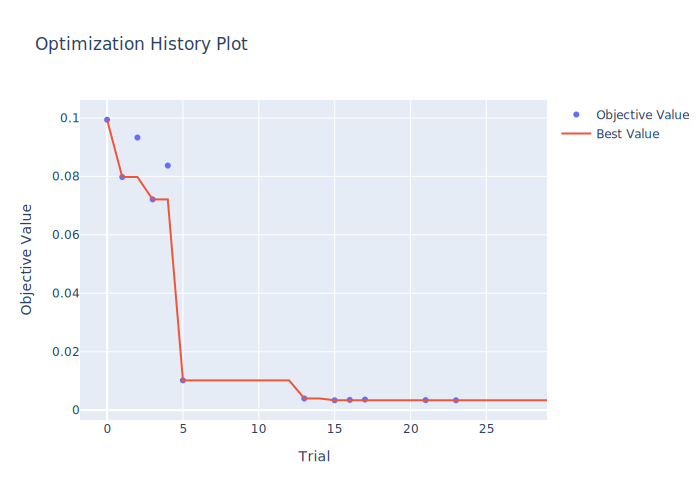

In [29]:
optuna.visualization.plot_optimization_history(study_lgb)

In [30]:
def create_fit_lgb(study, x, y):

    model = lgb.LGBMClassifier(
        **study.best_params, 
        n_estimators = study.best_trial.user_attrs['iterations'],
        verbosity=-1
    )
    model.fit(x, y)

    return model

model_lgb = create_fit_lgb(study_lgb, X_train, y_train)

-------------------- Evaulation scores --------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.83      0.89        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

-----------------------------------------------------------
AUCPR score: 0.8893

-----------------------------------------------------------
Metrics when different threshold is used on test data: 


,threshold,precision,recall,FN,FP,TP,TN
0,0.1,0.972222,0.714286,28,2,70,56862
1,0.2,0.962963,0.795918,20,3,78,56861
2,0.3,0.963415,0.806122,19,3,79,56861
3,0.4,0.964286,0.826531,17,3,81,56861
4,0.5,0.964286,0.826531,17,3,81,56861
5,0.6,0.964286,0.826531,17,3,81,56861
6,0.7,0.954023,0.846939,15,4,83,56860
7,0.8,0.943182,0.846939,15,5,83,56859
8,0.9,0.868687,0.877551,12,13,86,56851


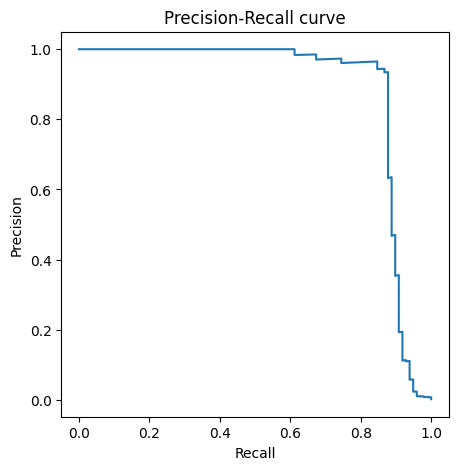

In [31]:
result_lgb = evaluate_model(model_lgb, X_test, y_test)

In [32]:
model_lgb.booster_.save_model(os.path.join(FOLDER_TO_SAVE_MODELS,f"LGB-{datetime.now().strftime('%Y%m%d')}.txt"))

# Example to load model
# loaded_model_lgb = lgb.Booster(model_file='mode.txt')

### Model comparison

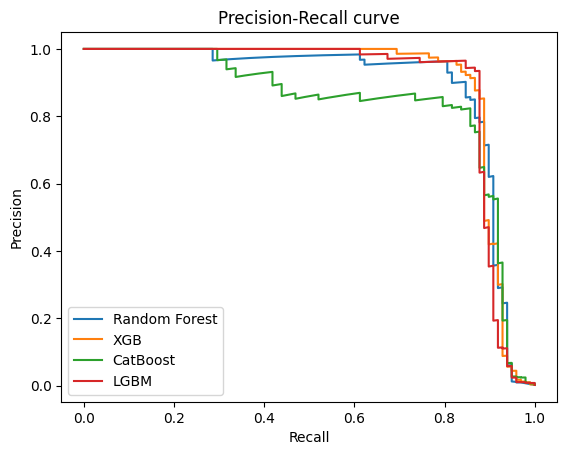

In [33]:
results= {
    'Random Forest':result_rf,
    'XGB':result_xgb,
    'CatBoost':result_cb,
    'LGBM':result_lgb
}

f,ax = plt.subplots(1)

for result in results.items():
    ax.plot(result[1][2], result[1][3], label=result[0])

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall curve')

ax.legend(loc='lower left')
plt.show()

In [34]:
aucpr_dict = dict()
for result in results.items():
    aucpr_dict[result[0]] = [result[1][1]]

aucpr_df = pd.DataFrame(aucpr_dict).T
aucpr_df.columns = ['AUCPR score']
aucpr_df

,AUCPR score
Random Forest,0.884953
XGB,0.898139
CatBoost,0.832171
LGBM,0.889305


In [35]:
def create_df(results_dict, relevant_cols):
    # Initialize an empty dataframe
    merged_df = pd.DataFrame()

    # Iterate through the list of tuples and merge the dataframes
    for name, df in [(result[0], result[1][0]) for result in results_dict.items()]:
        if merged_df.empty:
            merged_df = df[['threshold']].copy()
            merged_df.columns = pd.MultiIndex.from_tuples([('', col) for col in merged_df.columns])
        
        df = df[relevant_cols]
        df.columns = pd.MultiIndex.from_tuples([(name, col) for col in df.columns])
        merged_df = merged_df.merge(df, left_index=True, right_index=True, how='outer')
        
    return merged_df

create_df(results_dict=results, relevant_cols=['precision','recall'])    

Random Forest                 XGB            CatBoost            \
  threshold     precision    recall precision    recall precision    recall   
0       0.1      0.955224  0.653061  0.964286  0.826531  0.857143  0.795918   
1       0.2      0.961039  0.755102  0.953488  0.836735  0.824742  0.816327   
2       0.3      0.962500  0.785714  0.931818  0.836735  0.821782  0.846939   
3       0.4      0.929412  0.806122  0.922222  0.846939  0.792453  0.857143   
4       0.5      0.892473  0.846939  0.913043  0.857143  0.754386  0.877551   
5       0.6      0.848485  0.857143  0.904255  0.867347  0.688000  0.877551   
6       0.7      0.825243  0.867347  0.885417  0.867347  0.580000  0.887755   
7       0.8      0.781818  0.877551  0.851485  0.877551  0.450000  0.918367   
8       0.9      0.676923  0.897959  0.750000  0.887755  0.272455  0.928571   

       LGBM            
  precision    recall  
0  0.972222  0.714286  
1  0.962963  0.795918  
2  0.963415  0.806122  
3  0.964286  0.826531  
4  0.964286  0.826531  
5  0.964286  0.826531  
6  0.954023  0.846939  
7  0.943182  0.846939  
8  0.868687  0.877551

In [36]:
create_df(results_dict=results, relevant_cols=['FN','FP','TP','TN'])    

Random Forest                XGB                CatBoost           \
  threshold            FN  FP  TP     TN  FN  FP  TP     TN       FN   FP  TP   
0       0.1            34   3  64  56861  17   3  81  56861       20   13  78   
1       0.2            24   3  74  56861  16   4  82  56860       18   17  80   
2       0.3            21   3  77  56861  16   6  82  56858       15   18  83   
3       0.4            19   6  79  56858  15   7  83  56857       14   22  84   
4       0.5            15  10  83  56854  14   8  84  56856       12   28  86   
5       0.6            14  15  84  56849  13   9  85  56855       12   39  86   
6       0.7            13  18  85  56846  13  11  85  56853       11   63  87   
7       0.8            12  24  86  56840  12  15  86  56849        8  110  90   
8       0.9            10  42  88  56822  11  29  87  56835        7  243  91   

         LGBM                 
      TN   FN  FP  TP     TN  
0  56851   28   2  70  56862  
1  56847   20   3  78  56861  
2  56846   19   3  79  56861  
3  56842   17   3  81  56861  
4  56836   17   3  81  56861  
5  56825   17   3  81  56861  
6  56801   15   4  83  56860  
7  56754   15   5  83  56859  
8  56621   12  13  86  56851

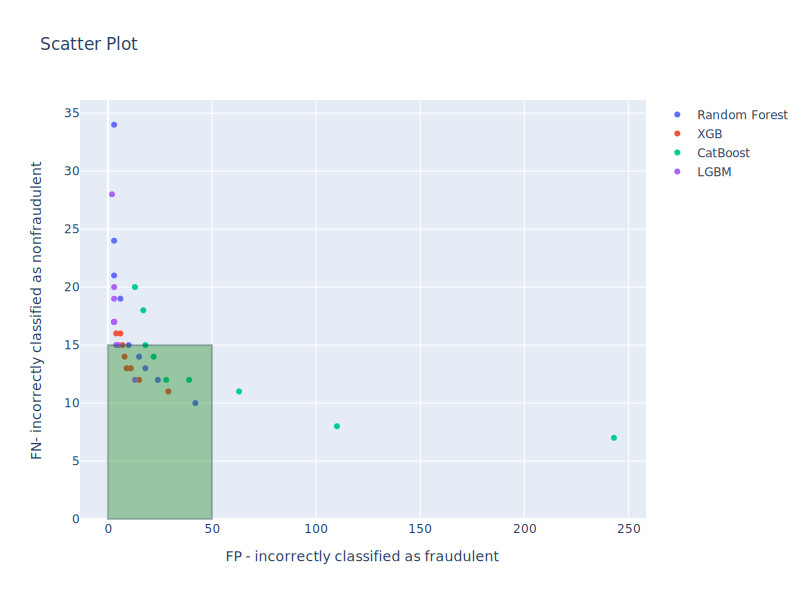

In [37]:
# Create a scatter plot for each dataset
fig = go.Figure()


for result in results.items():
    # Create custom hover text with the additional information
    hover_text = [f"{result[0]} at {info:.1f} threshold" for info in result[1][0]['threshold']]

    fig.add_trace(go.Scatter(
        x=result[1][0]['FP'], 
        y=result[1][0]['FN'], 
        mode='markers', 
        name=result[0],
        text=hover_text  # Assign the custom hover text here
    ))

    fig.add_shape(type="rect",
    xref="x", yref="y",
    x0=0, y0=0,
    x1=50, y1=15,
    fillcolor="green",
    opacity=0.1
    )


# Customize the layout, axis labels, and size
fig.update_layout(
    title='Scatter Plot',
    xaxis_title='FP - incorrectly classified as fraudulent',
    yaxis_title='FN- incorrectly classified as nonfraudulent',
    width=800,
    height=600
)

# Show the plot
fig.show()


### Conclusion:

We have achieved satisfactory predictive performance using all four models, despite the extremely imbalanced dataset.

I've highlighted the promising results on the above plot with a green rectangle based on my intuition. However, our ultimate decision regarding model selection and the threshold could depend on several crucial factors. For example, in a real-world scenario, the cost of misclassifying a fraudulent case as non-fraudulent may be significantly higher than misclassifying a non-fraudulent case as fraudulent. In such cases, further fine-tuning of the models is necessary, with a greater emphasis on recall rather than the overall AUCPR score.